### Style Transfer using CNN

Image style transfer is a way of transferring the style of one image (called style image) to another image (called content image).

More about it in this [paper](https://paperswithcode.com/task/style-transfer).


> How do we implement our own style transfer DL model

- Get a pretrained VGG model as our baseline.
- Implement the gram matrix, style and content loss functions.
- Train & tweak our model.
- Put the model to test.


In [1]:
# Required Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Get a pre-trained VGG model as our baseline model
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
layers = [layer.name for layer in vgg.layers]
layers

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool',
 'flatten',
 'fc1',
 'fc2',
 'predictions']

### [Gram Matrix](https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916)



[Video Link](https://www.youtube.com/watch?v=AIK6Gi3NUhI)

<img src="https://i.ytimg.com/vi/Elxnzxk-AUk/maxresdefault.jpg" width=500 height=400/>




> Applying a gram matrix to features extracted from convolutional neural networks helps to create texture information related to the data. The Gram Matrix is defined using the following simple equation: Gram=V^T V. Here, V is an arbitrary vector and multiply with its transpose.



#### In NST, the gram matrix equation is given by

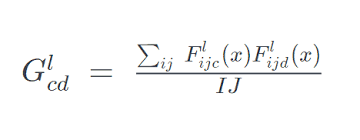


### Create function for Gram Matrix

In [3]:
def get_gram_matrix(matrix: tf.Tensor) -> tf.Tensor:
    """
    Takes in an image tensor and computes the gram matrix 
    for it.

    Params:
        matrix (tf.Tensor) : An image tensor

    Returns:
        (tf.Tensor) : The computed gram matrix of the input tensor
    """
    numerator = tf.einsum("bijc,bijd->bcd", matrix, matrix)
    numerator_result = tf.expand_dims(numerator, axis=0)
    matrix_shape = tf.shape(matrix)
    denominator = tf.cast(matrix_shape[1] * matrix_shape[2], tf.float32)
    return numerator_result / denominator

### Create a model taking VGG19 as our baseline

In [4]:
CONTENT_LAYER = "block4_conv2"
STYLE_LAYERS = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

def load_vgg() -> tf.keras.Model:
    """
    Loads the pre-trained VGG19 model from tensorflow.keras.applications

    Params:
        None
    
    Returns:
        (tf.keras.Model) : Pre-trained VGG19 model
    """
    vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")
    # vgg.load_weights(WEIGHTS_URL)
    vgg.trainable = False

    content_res = vgg.get_layer(CONTENT_LAYER).output
    style_res = [vgg.get_layer(layer).output for layer in STYLE_LAYERS]
    gram_style_res = [get_gram_matrix(output) for output in style_res]

    model = tf.keras.Model([vgg.input], [content_res, gram_style_res])
    return model

### Load & Display, Content and Style Images

In [5]:
def load_display_images(content_img_path: str, style_img_path: str) -> tuple:
    """
    Takes content and style images path and loads as well as 
    displays them

    Params:
        content_img_path (str) : Content image path
        style_img_path (str) : Style image path

    Returns:
        (tuple) : Both the content and style image representation inside a tuple
    """
    content_image = cv2.resize(cv2.imread(content_img_path), (224, 224))
    content_image = tf.image.convert_image_dtype(content_image, tf.float32)
    style_image = cv2.resize(cv2.imread(style_img_path), (224, 224))
    style_image = tf.image.convert_image_dtype(style_image, tf.float32)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(content_image)
    ax2.imshow(style_image)

    return content_image, style_image

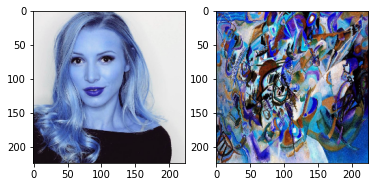

In [6]:
img_tensors = load_display_images("test.jpg", "style.jpg")

### Style & Content Loss

> Content Loss

<img src="https://miro.medium.com/max/1400/0*MYoOY9r_5KKQD7Ld" width=500 height=300>


> Style Loss

<img src="https://miro.medium.com/max/1400/1*6ZqgAS5gDn25jncXDRfqog.png" width=500 height=300>

> Total Loss

T.L = (content_weight * content_loss) + (style_weight * style_loss)

In [7]:
STYLE_WEIGHT = 1e-2
CONTENT_WEIGHT = 1e-3

def get_loss(style_outputs: tf.Tensor, 
             style_target: tf.Tensor, 
             content_outputs: tf.Tensor, 
             content_target: tf.Tensor) -> float:
    """
    Computes the loss function in terms of style and content loss

    Params:
    style_outputs (tf.Tensor) : 
    style_target (tf.Tensor) : 
    content_outputs (tf.Tensor) :
    content_target (tf.Tensor) :

    Returns:
        (float) : The total loss

    """
    content_loss = tf.reduce_mean((content_outputs - content_target) ** 2)
    style_loss = tf.add_n(tf.reduce_mean((output - target) ** 2) for output, target in zip(style_outputs, style_target))

    total_loss = (STYLE_WEIGHT * style_loss) + (CONTENT_WEIGHT * content_loss)
    return total_loss

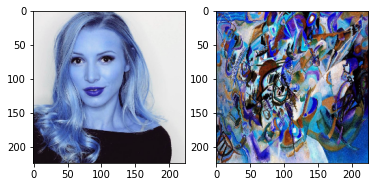

In [8]:
# Get the model ready for training
vgg_model = load_vgg()

content_image, style_image = load_display_images("test.jpg", "style.jpg")

content_target = vgg_model(np.array([content_image * 255]))[0]
style_target = vgg_model(np.array([style_image * 255]))[1]

In [44]:
def apply_gradients(image: tf.Tensor, epoch: int) -> None:
    """
    Trains the model for the given number of epochs

    Params:
        image (tf.Tensor) : Image to train model on
        epochs (int) : Number of epochs
    
    Returns:
        None
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    with tf.GradientTape() as tape:
        output = vgg_model(image * 255)
        loss = get_loss(output[1], style_target, output[0], content_target)
    
    gradient = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradient, image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)) # Important step to avoid dilution of image

    if epoch % 100 == 0:
        print(f"Loss:", loss)

In [47]:
epochs = 50 # With lr=0.01, 15 <= epochs <= 50 yield good results
image = tf.Variable([content_image]) # Make image variable so its pixel values can be changed

for epoch in range(epochs):
    apply_gradients(image, epoch)

Loss: tf.Tensor(16170275000.0, shape=(), dtype=float32)


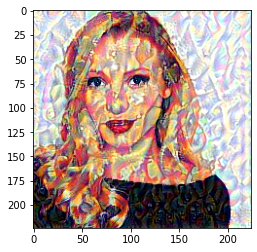

In [48]:
image = cv2.cvtColor(np.float32(tf.squeeze(image)), cv2.COLOR_BGR2RGB)
plt.imshow(tf.squeeze(image))